<a href="https://colab.research.google.com/github/Ravi-ranjan1801/CUDA-Lab/blob/main/lab_02_final_cu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%writefile q1_vector_add_simple.cu
#include <stdio.h>
#include <cuda.h>
#include <time.h>
#include <stdlib.h>

#define BLOCK 256
#define TESTS 4   // fewer test points for simplicity

__global__ void addKernel(const int *A, const int *B, int *C, int N) {
    int id = blockIdx.x * blockDim.x + threadIdx.x;
    if (id < N) C[id] = A[id] + B[id];
}

int main() {
    int maxN;
    printf("Enter maximum N: ");
    if (scanf("%d", &maxN) != 1) return 0;

    FILE *f = fopen("q1_times.csv","w");
    if (!f) { perror("fopen"); return 0; }
    fprintf(f, "N,CPU_s,GPU_s\n");

    for (int t = 1; t <= TESTS; ++t) {
        int N = maxN * t / TESTS;
        size_t bytes = (size_t)N * sizeof(int);

        int *hA = (int*)malloc(bytes), *hB = (int*)malloc(bytes), *hC = (int*)malloc(bytes);
        for (int i = 0; i < N; ++i) { hA[i] = i; hB[i] = i; }

        // CPU timing
        clock_t cs = clock();
        for (int i = 0; i < N; ++i) hC[i] = hA[i] + hB[i];
        clock_t ce = clock();
        double cpu = (double)(ce - cs) / CLOCKS_PER_SEC;

        // GPU timing (kernel only)
        int *dA, *dB, *dC;
        cudaMalloc(&dA, bytes); cudaMalloc(&dB, bytes); cudaMalloc(&dC, bytes);
        cudaMemcpy(dA, hA, bytes, cudaMemcpyHostToDevice);
        cudaMemcpy(dB, hB, bytes, cudaMemcpyHostToDevice);

        cudaEvent_t s,e; cudaEventCreate(&s); cudaEventCreate(&e);
        cudaEventRecord(s);
        int grid = (N + BLOCK - 1) / BLOCK;
        addKernel<<<grid, BLOCK>>>(dA, dB, dC, N);
        cudaEventRecord(e); cudaEventSynchronize(e);

        float gpu_ms = 0.0f; cudaEventElapsedTime(&gpu_ms, s, e);
        double gpu = gpu_ms / 1000.0;

        // optional copy back to verify
        // cudaMemcpy(hC, dC, bytes, cudaMemcpyDeviceToHost);

        printf("N=%d  CPU=%.6f s  GPU=%.6f s\n", N, cpu, gpu);
        fprintf(f, "%d,%.6f,%.6f\n", N, cpu, gpu);

        cudaFree(dA); cudaFree(dB); cudaFree(dC);
        cudaEventDestroy(s); cudaEventDestroy(e);
        free(hA); free(hB); free(hC);
    }

    fclose(f);
    printf("Saved q1_times.csv\n");
    return 0;
}


Writing q1_vector_add_simple.cu


In [2]:
!nvcc q1_vector_add_simple.cu -o q1_add
!./q1_add

Enter maximum N: 1000000
N=250000  CPU=0.001126 s  GPU=0.039382 s
N=500000  CPU=0.002466 s  GPU=0.000003 s
N=750000  CPU=0.003357 s  GPU=0.000003 s
N=1000000  CPU=0.004338 s  GPU=0.000003 s
Saved q1_times.csv


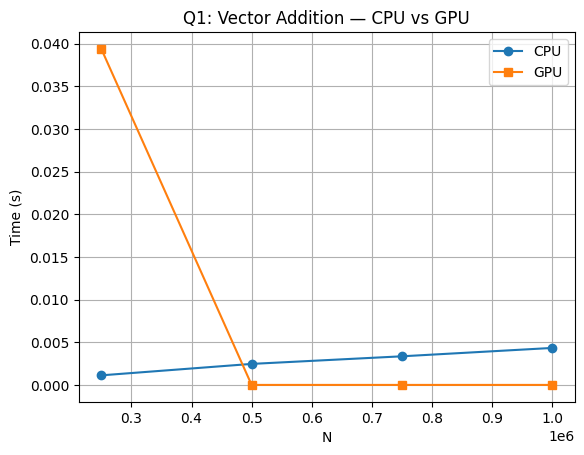

In [3]:
import pandas as pd, matplotlib.pyplot as plt
df = pd.read_csv("q1_times.csv")
plt.plot(df['N'], df['CPU_s'], marker='o', label='CPU')
plt.plot(df['N'], df['GPU_s'], marker='s', label='GPU')
plt.xlabel('N'); plt.ylabel('Time (s)')
plt.title('Q1: Vector Addition — CPU vs GPU'); plt.legend(); plt.grid(True); plt.show()


In [4]:
%%writefile q2_sum_min_max_simple.cu
#include <stdio.h>
#include <cuda.h>
#include <time.h>
#include <limits.h>
#include <stdlib.h>

#define BLOCK 256
#define TESTS 4

// Each block produces one partial (sum/min/max) at index blockIdx.x
__global__ void blockReduce(const int *arr, int N, int *part_sum, int *part_min, int *part_max) {
    __shared__ int ssum[BLOCK];
    __shared__ int smin[BLOCK];
    __shared__ int smax[BLOCK];

    int tid = threadIdx.x;
    int idx = blockIdx.x * blockDim.x + tid;

    if (idx < N) {
        ssum[tid] = arr[idx];
        smin[tid] = arr[idx];
        smax[tid] = arr[idx];
    } else {
        ssum[tid] = 0;
        smin[tid] = INT_MAX;
        smax[tid] = INT_MIN;
    }
    __syncthreads();

    // in-block reduction
    for (int stride = blockDim.x/2; stride > 0; stride >>= 1) {
        if (tid < stride) {
            ssum[tid] += ssum[tid+stride];
            if (smin[tid+stride] < smin[tid]) smin[tid] = smin[tid+stride];
            if (smax[tid+stride] > smax[tid]) smax[tid] = smax[tid+stride];
        }
        __syncthreads();
    }

    if (tid == 0) {
        int b = blockIdx.x;
        part_sum[b] = ssum[0];
        part_min[b] = smin[0];
        part_max[b] = smax[0];
    }
}

int main() {
    int maxN;
    printf("Enter maximum N: ");
    if (scanf("%d", &maxN) != 1) return 0;

    FILE *f = fopen("q2_times.csv","w");
    if (!f) { perror("fopen"); return 0; }
    fprintf(f, "N,CPU_s,GPU_s\n");

    for (int t = 1; t <= TESTS; ++t) {
        int N = maxN * t / TESTS;
        size_t bytes = (size_t)N * sizeof(int);
        int *h = (int*)malloc(bytes);
        for (int i = 0; i < N; ++i) h[i] = i % 100; // values 0..99

        // CPU compute
        clock_t cs = clock();
        long long cpu_sum = 0;
        int cpu_min = h[0], cpu_max = h[0];
        for (int i = 0; i < N; ++i) {
            cpu_sum += h[i];
            if (h[i] < cpu_min) cpu_min = h[i];
            if (h[i] > cpu_max) cpu_max = h[i];
        }
        clock_t ce = clock();
        double cpu = (double)(ce - cs) / CLOCKS_PER_SEC;

        // GPU compute
        int grid = (N + BLOCK - 1) / BLOCK;
        // allocate device arrays
        int *d_arr, *d_psum, *d_pmin, *d_pmax;
        cudaMalloc(&d_arr, bytes);
        cudaMalloc(&d_psum, grid * sizeof(int));
        cudaMalloc(&d_pmin, grid * sizeof(int));
        cudaMalloc(&d_pmax, grid * sizeof(int));
        cudaMemcpy(d_arr, h, bytes, cudaMemcpyHostToDevice);

        cudaEvent_t s,e; cudaEventCreate(&s); cudaEventCreate(&e);
        cudaEventRecord(s);
        blockReduce<<<grid, BLOCK>>>(d_arr, N, d_psum, d_pmin, d_pmax);
        cudaEventRecord(e); cudaEventSynchronize(e);
        float gpu_ms = 0.0f; cudaEventElapsedTime(&gpu_ms, s, e);
        double gpu = gpu_ms / 1000.0;

        // copy partials back and finish on CPU
        int *ps = (int*)malloc(grid * sizeof(int));
        int *pmn = (int*)malloc(grid * sizeof(int));
        int *pmx = (int*)malloc(grid * sizeof(int));
        cudaMemcpy(ps, d_psum, grid * sizeof(int), cudaMemcpyDeviceToHost);
        cudaMemcpy(pmn, d_pmin, grid * sizeof(int), cudaMemcpyDeviceToHost);
        cudaMemcpy(pmx, d_pmax, grid * sizeof(int), cudaMemcpyDeviceToHost);

        long long gpu_sum = 0;
        int gpu_min = pmn[0], gpu_max = pmx[0];
        for (int i = 0; i < grid; ++i) {
            gpu_sum += ps[i];
            if (pmn[i] < gpu_min) gpu_min = pmn[i];
            if (pmx[i] > gpu_max) gpu_max = pmx[i];
        }

        printf("N=%d  CPU_s=%.6f  GPU_s=%.6f  CPU(sum,min,max)=(%lld,%d,%d)  GPU(sum,min,max)=(%lld,%d,%d)\n",
               N, cpu, gpu, cpu_sum, cpu_min, cpu_max, gpu_sum, gpu_min, gpu_max);

        fprintf(f, "%d,%.6f,%.6f\n", N, cpu, gpu);

        // cleanup
        free(h); free(ps); free(pmn); free(pmx);
        cudaFree(d_arr); cudaFree(d_psum); cudaFree(d_pmin); cudaFree(d_pmax);
        cudaEventDestroy(s); cudaEventDestroy(e);
    }

    fclose(f);
    printf("Saved q2_times.csv\n");
    return 0;
}


Writing q2_sum_min_max_simple.cu


In [5]:
!nvcc q2_sum_min_max_simple.cu -o q2_q
!./q2_q

Enter maximum N: 1000000
N=250000  CPU_s=0.001559  GPU_s=0.007525  CPU(sum,min,max)=(12375000,0,99)  GPU(sum,min,max)=(0,0,0)
N=500000  CPU_s=0.001632  GPU_s=0.000003  CPU(sum,min,max)=(24750000,0,99)  GPU(sum,min,max)=(0,0,0)
N=750000  CPU_s=0.002444  GPU_s=0.000003  CPU(sum,min,max)=(37125000,0,99)  GPU(sum,min,max)=(0,0,0)
N=1000000  CPU_s=0.004904  GPU_s=0.000003  CPU(sum,min,max)=(49500000,0,99)  GPU(sum,min,max)=(0,0,0)
Saved q2_times.csv


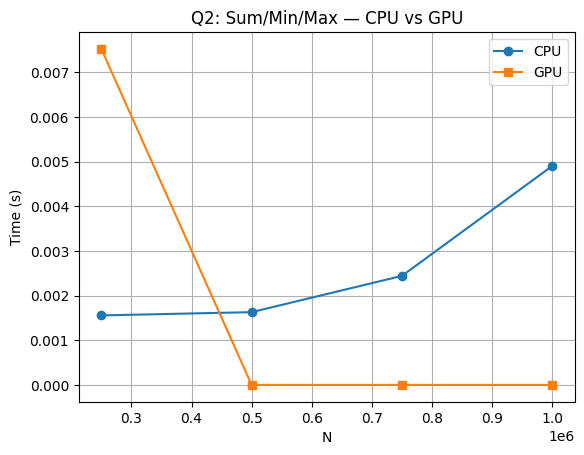

In [6]:
import pandas as pd, matplotlib.pyplot as plt
df = pd.read_csv("q2_times.csv")
plt.plot(df['N'], df['CPU_s'], marker='o', label='CPU')
plt.plot(df['N'], df['GPU_s'], marker='s', label='GPU')
plt.xlabel('N'); plt.ylabel('Time (s)')
plt.title('Q2: Sum/Min/Max — CPU vs GPU'); plt.legend(); plt.grid(True); plt.show()
